In [2]:
# Import libraries
import cv2
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.optimizers import Adam
from keras.layers import Dropout, AveragePooling2D, Flatten, Dropout, Dense, Input, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
# initialize the initial learning rate, number of epochs, and batch size
LEARNING_RATE = 1e-4
EPOCHS = 20
BATCH_SIZE = 32

In [3]:
# define directory and categories
DIRECTORY = "./dataset"
CATEGORIES = ['with_mask', 'without_mask']

In [4]:
# load the image data
print(f'[INFO] Loading the images...')

data = []
label = []
for category in CATEGORIES:
     path = os.path.join(DIRECTORY, category)
     for image in os.listdir(path):
          image_path = os.path.join(path, image)
          image = load_img(image_path, target_size=(200, 200))
          image = img_to_array(image)
          image = preprocess_input(image)

          data.append(image)
          label.append(category)

[INFO] Loading the images...


c:\users\development 2\appdata\local\programs\python\python37\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [5]:
# Data Preprocessing
# perform one hot encoding to the labels
lb = LabelBinarizer()
label = lb.fit_transform(label)
label = to_categorical(label)

 
# convert list to numpy array
data = np.array(data, dtype='float32')
labels = np.array(label)

In [6]:
# split the image dataset to train and test data
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                   stratify=labels, random_state=42)

In [7]:
print()
print('[INFO] Start data augmentation...')
# augment image data
data_augment = ImageDataGenerator(rotation_range=20,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.15,
                           zoom_range=0.15,
                           horizontal_flip=True,
                           fill_mode='nearest')



[INFO] Start data augmentation...


In [8]:
# Building a CNN model
print()
print('Building the CNN model')

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid')) # output layer


Building the CNN model


In [9]:
print()
print('[INFO] Compiling the model...')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



[INFO] Compiling the model...


In [10]:
print()
print('[INFO] Summary of the model...')
print(model.summary())


[INFO] Summary of the model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoo

In [11]:
# Define early stop and checkpoint
early_stop = EarlyStopping(
     monitor='loss',
     min_delta=0.001,
     patience=3,
     mode='min',
     verbose=0
) 
checkpoint = ModelCheckpoint(
     'model_best_weights.h5', 
     monitor='loss', 
     verbose=0, 
     save_best_only=True,  
     mode='min', 
     save_freq=1
)

In [12]:
# Train the model
print()
print('[INFO] Training the model...')
model = model.fit(data_augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
               validation_data = (x_test, y_test),
               epochs=EPOCHS, callbacks = [early_stop,checkpoint])



[INFO] Training the model...
Epoch 1/20
239/239 [==============================] - 591s 2s/step - loss: 0.2949 - accuracy: 0.8778 - val_loss: 0.1809 - val_accuracy: 0.9182
Epoch 2/20
239/239 [==============================] - 549s 2s/step - loss: 0.2192 - accuracy: 0.9076 - val_loss: 0.1325 - val_accuracy: 0.9423
Epoch 3/20
239/239 [==============================] - 604s 3s/step - loss: 0.1921 - accuracy: 0.9223 - val_loss: 0.1172 - val_accuracy: 0.9476
Epoch 4/20
239/239 [==============================] - 700s 3s/step - loss: 0.1740 - accuracy: 0.9280 - val_loss: 0.1560 - val_accuracy: 0.9434
Epoch 5/20
239/239 [==============================] - 658s 3s/step - loss: 0.1543 - accuracy: 0.9393 - val_loss: 0.1587 - val_accuracy: 0.9371
Epoch 6/20
239/239 [==============================] - 624s 3s/step - loss: 0.1492 - accuracy: 0.9456 - val_loss: 0.1027 - val_accuracy: 0.9581
Epoch 7/20
239/239 [==============================] - 528s 2s/step - loss: 0.1313 - accuracy: 0.9528 - val_loss:

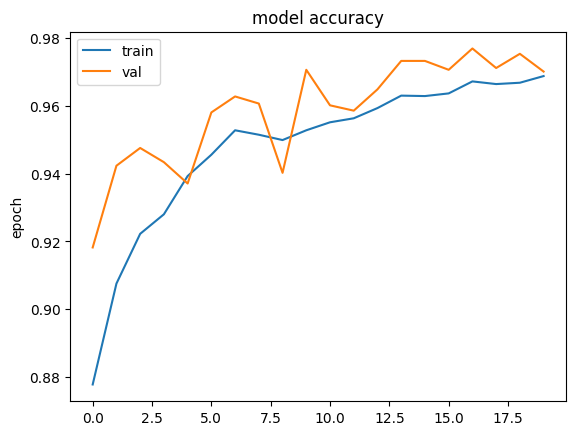

In [13]:
# Plot the training loss and accuracy
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

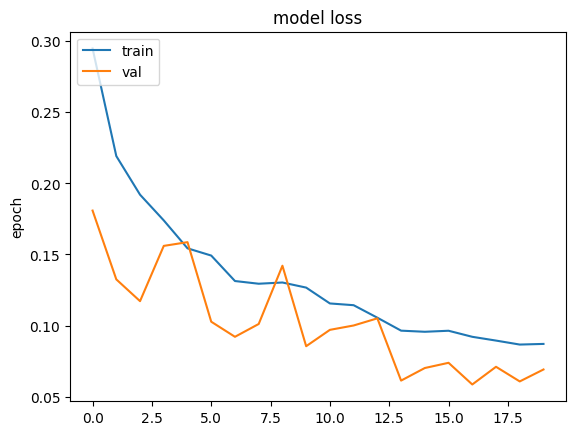

In [14]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_loss.png')
plt.show()

[INFO] starting image detection...

Image name: image_1.jpg
1/1 [==============================] - 0s 78ms/step
The image is: Mask.
Confidence is: 67.41%


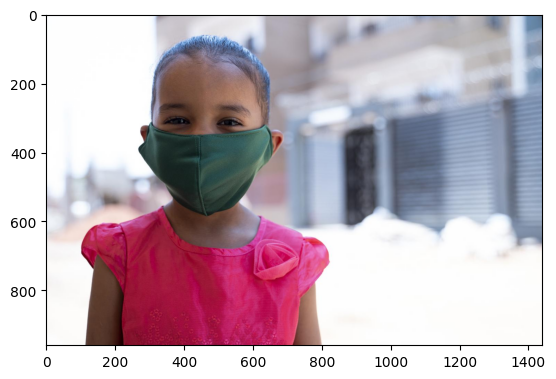


Image name: image_2.jpg
1/1 [==============================] - 0s 31ms/step
The image is: Mask.
Confidence is: 65.75%


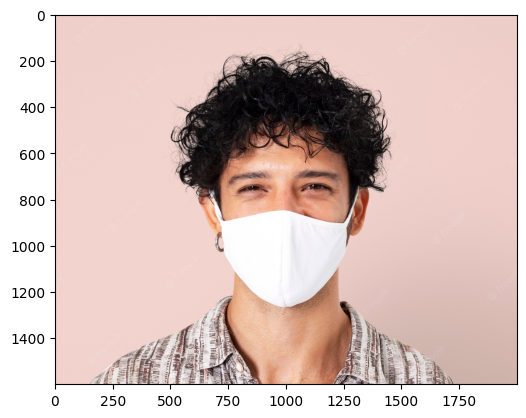


Image name: image_3.jpg
1/1 [==============================] - 0s 24ms/step
The image is: Unmask.
Confidence is: 99.99%


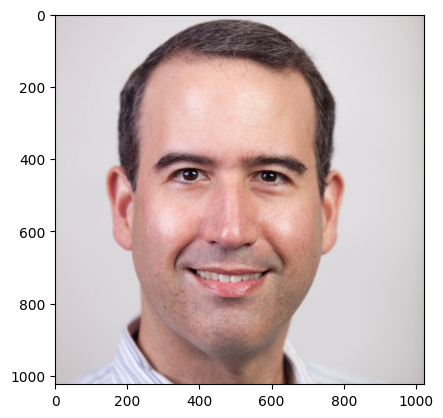


Image name: image_4.jpg
1/1 [==============================] - 0s 25ms/step
The image is: Unmask.
Confidence is: 57.28%


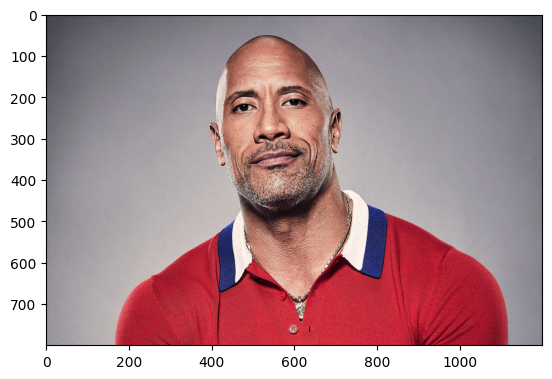

In [11]:
# Predict new images using the model

image_filepath = './sample_images/'
model = load_model("model_best_weights.h5")

print("[INFO] starting image detection...")

def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval


def natural_keys(text):
    """alist.sort(key=natural_keys) sorts in human order"""
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]


folder_files = os.listdir(image_filepath)
folder_files.sort(key=natural_keys)


for filename in folder_files:
    print()
    print(f'Image name: {filename}')

    original_face = cv2.imread(os.path.join(image_filepath, filename))
    rgb_face = cv2.cvtColor(original_face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(rgb_face, (200, 200))
    face = img_to_array(face)
    face = preprocess_input(face)
    
    face_list = []
    face_list.append(face)

    faces = np.array(face_list, dtype="float32")
    preds = model.predict(faces, batch_size=32)

    label = np.argmax(preds)
    label = 'Mask' if label==0 else 'Unmask'

    confidence = round(max(preds[0])*100, 2)

    
    print(f'The image is: {label}.\nConfidence is: {confidence}%')
    imgplot = plt.imshow(rgb_face)
    plt.show()